In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import os

In [8]:
Duration_Weight = {
    'Eat':2,
    'Sleep':2,
    'Medicine': 0
}
Start_Weight = {
    'Medicine': 2,
    'Eat':1.2,
    'Sleep':1,
}

# converts 'hh:mm:ss' format to seconds
def sec(s):
    h, m, s = map(int, s.split(':'))
    return h*3600 + m*60 + s


In [9]:
def fitS(x1, x2, act):
    x = abs(x2-x1)
    n = 3
    b = 4000
    C = 50
    
    score = C*exp(-(x/b)**n)
    score = score*Start_Weight[act]
    return score
    
def fitD(x1, x2,  act):
    Width = {'Sleep':2, 'Medicine': 1, 'Eat': 1, 'Bathe': 0.8}
    
    x = abs(x2-x1)
    n = 3
    b = 1400*Width[act]
    C = 50
    
    score = C*exp(-(x/b)**n)
    score = score*Duration_Weight[act]
    return score

In [10]:
eat = ['Eat', 'Eat_Breakfast', 'Eat_Lunch', 'Eat_Dinner']
sleep = ['Sleep']
med = ['Medicine','Morning_Meds', 'Evening_Meds','Take_Medicine']
A = {'Eat': eat,  'Sleep': sleep, 'Medicine': med}

# Return Fitness score of whole Day
def fitness_day(normal, day, d):
    Score = 0
    
    for act in A:
        day_act = day[day['Activity'].isin(A[act])] 
        normal_act = normal[normal['Activity'] == act]
        #print(act)
        score = fitness_activity(normal_act, day_act, act)
        Score += score
    return Score

# Returns Fitness Score of all activities of same type (like eat_breakfast, eat_lunch etc.)
def fitness_activity(normal, day, act):
    Score = 0
    n = len(normal)
    m = len(day)
    
    for i in range(n):
        maxx = 0
        for j in range(m):
            row1 = normal.iloc[i]
            row2 = day.iloc[j]
            
            score = fitness(row1, row2, act)
            maxx = max(maxx, score)
        Score += maxx
        
    return Score

#Returns Start Time Score + Duration score of one activity only     
def fitness(row1, row2, act):
    normal_start = row1['Start']*60*60
    normal_duration = row1['Duration']*60
    
    day_start = sec(row2['Start'])
    day_finish = sec(row2['Finish'])
    day_duration = day_finish - day_start
    
    score = 0
    score += fitS(normal_duration, day_duration, act)
    score += fitD(day_duration, day_start, act)

    return score

In [14]:
#Sequence related Functions
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

short = {
    'Sleep': 'S',
    'Morning_Meds': 'M',
    'Evening_Meds':'M',
    'Bathe': 'B',
    'Cook': 'C',
    'Cook_Breakfast': 'C',
    'Cook_Dinner': 'C',
    'Cook_Lunch': 'C',
    'Eat': 'E',
    'Eat_Breakfast':'E',
    'Eat_Dinner':'E',
    'Eat_Lunch':'E',
    'Wash_Breakfast_Dishes': 'W',
    'Wash_Dinner_Dishes': 'W',
    'Wash_Dishes': 'W',
    'Wash_Lunch_Dishes':'W'
}

# Returns Sequence of day in dataset
def get_day_sequence(dataset, day):
    readpath = r'..\CASAS_DATA\HH' +dataset+ r'\filling\Day' + str(day) + '.csv'
    df = pd.read_csv(readpath)
    Act = list(df['Activity'])

    sequence = ['@']
    for act in Act:
        if act in short:
            if sequence[-1] != short[act]:
                sequence.append(short[act])
    seq = ''.join(sequence)
    return seq

# Returns List of Sequences of all days in a dataset
def get_sequences(dataset):
    dirc = r'..\CASAS_DATA\HH' +dataset+ r'\train_data'
    Days = len(os.listdir(dirc))
    SEQ = []
    for day in range(1, Days+1):
        seq = get_day_sequence(dataset, day)
        SEQ.append(seq[1:])
    return SEQ

# Compares a sequence to all normal Sequences and returns best matching sequence percentage
def compare_sequence(normals, sequence):
    best_day, best_score = 0, 0
    best_alignment = None
    best_percentage = 0
    day = 1
    while day < len(normals):
        X = normals[day]
        Y = sequence
        alignments = pairwise2.align.localxx(X, Y)

        for a in alignments:
            if a.score >= best_score:
                best_percentage = (a.score/len(X))*100
                best_day = day
                best_alignment = a
        day += 1
        
    return best_percentage


In [15]:
# Plots Day vs Fitness Score

def get_fitness_plot(trained, test, data_type):
    if data_type == 'filling':
        trained_dataset = pd.read_csv(r'..\CASAS_DATA\HH' + trained + r'\Filled_Activites\Normal.csv')
    else:
        trained_dataset = pd.read_csv(r'..\CASAS_DATA\HH' + trained + r'\Activities\Normal.csv')
    seq_df = pd.read_csv(r'..\CASAS_DATA\HH' + trained +'\Activities\Sequence.csv')
    train_seqs = list(seq_df['Sequence'])
    
    count = 1
    
    Fitness_Days = []
    
    # PlotLines
    Fitness_Score = []
    Sequence_Score = []
    Location_Anomaly = []
    
    #Threshhold, horizontal lines
    Fitness_threshold = 10000  
    Sequence_threshold = 60
    change = []
    
    for dataset in test:
        Day_start = 1
        Day_end = 0
        if dataset == trained:
            if data_type == 'filling':
                dirc = r'..\CASAS_DATA\HH' + dataset + r'\filling_test' 
                Day_end = len(os.listdir(dirc))
            else:
                dirc = r'..\CASAS_DATA\HH' + dataset + r'\test_data' 
                Day_end = len(os.listdir(dirc))
        else:
            dirc = r'..\CASAS_DATA\HH' + dataset + '\\' + data_type
            Day_end = len(os.listdir(dirc))
       

        for day in range(Day_start, Day_end):
            read_path = ''
            
            if dataset == trained:
                if data_type == 'filing':
                    read_path = r'..\CASAS_DATA\HH' + dataset + r'\filling_test\Day' + str(day) + r'.csv'
                else:
                    read_path = r'..\CASAS_DATA\HH' + dataset + r'\test_data\Day' + str(day) + r'.csv'
            else:
                read_path = r'..\CASAS_DATA\HH' + dataset + '\\' + data_type + r'\Day' + str(day) + r'.csv'
            
            
            day_df = pd.read_csv(read_path)
            
            
            day_seq = get_day_sequence(dataset, day)
                
            seq_score  = compare_sequence(train_seqs, day_seq)
            fitness_score = fitness_day(trained_dataset, day_df, day)
            fs = float('%.1f'%fitness_score)
            
            if dataset == trained:
                Fitness_threshold = min(Fitness_threshold, fs-25)
            
            Sequence_Score.append(seq_score)
            Fitness_Days.append(count)
            count += 1
            Fitness_Score.append(fs)
            #print('Day:'+str(day),fs)
        change.append(count)
    
    fig = plt.figure(figsize=(13,8))
    
    #plot Scores
    plt.plot(Fitness_Days, Fitness_Score, marker = 'o', mfc = 'r', label = 'Fitness Score')
    plt.plot(Fitness_Days, Sequence_Score,  mec = 'teal' ,marker = 'D', mfc = 'magenta', label = 'Sequence Score', color = 'teal')
    
    #Plot Details
    title = trained + ' Trained  | ' + ' Testing on ' + ', '.join(test) + ' ' + data_type
    plt.title(title,fontdict = {'fontsize' : 20})
    plt.xlabel('Days',fontdict = {'fontsize' : 13})
    plt.ylabel('Score', fontdict = {'fontsize' : 13})
   
    
    #plot Threshhold lines
    plt.plot([1, max(Fitness_Days)], [Sequence_threshold, Sequence_threshold], color = 'magenta', label= 'Sequence Threshold ')
    #plt.plot([1, max(Fitness_Days)], [Fitness_threshold, Fitness_threshold], color = 'r', label= 'Fitness Threshold ')
    
    #plot Datset change lines
    plt.plot([0,0], [1, max(Fitness_Score) + 50], color='orange', linestyle='--', linewidth=2, label = 'Dataset Division Line')
    for c in change:
        plt.plot([c,c], [1, max(Fitness_Score) + 50], color='orange', linestyle='--', linewidth=2)
    
    plt.xlim([0,max(Fitness_Days)+3])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

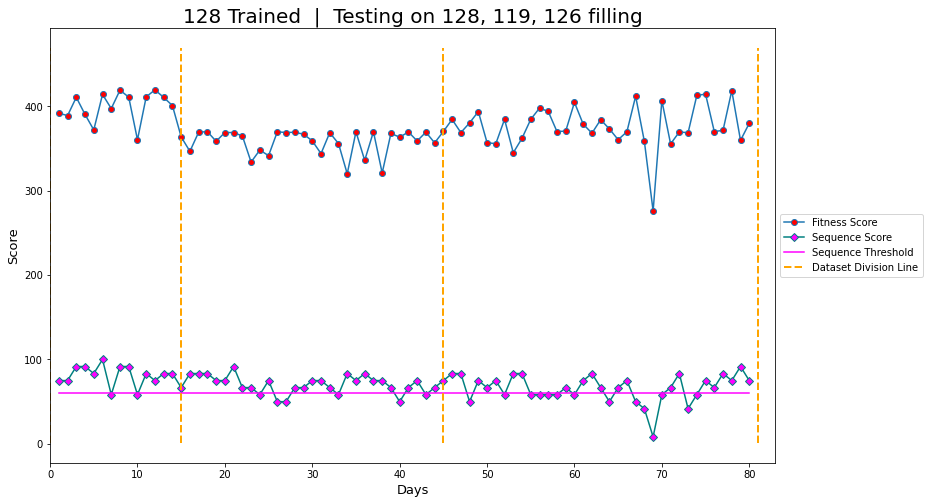

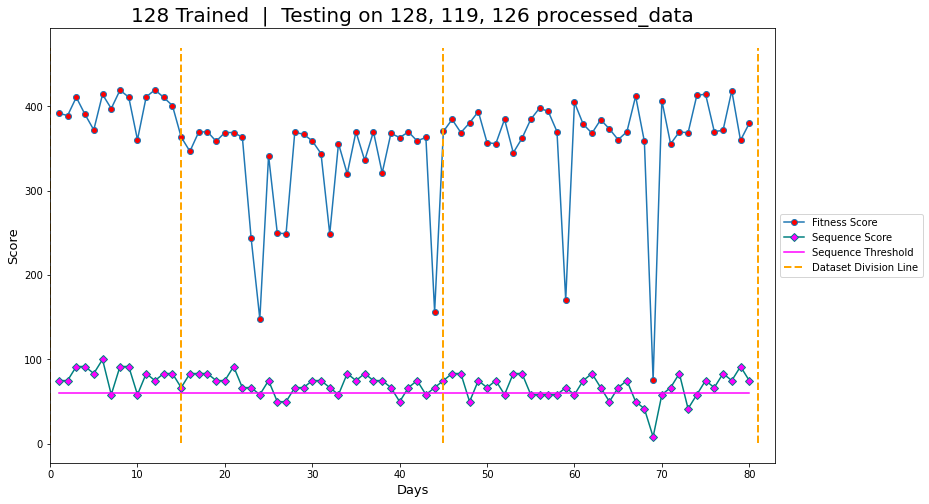

In [16]:
#1
get_fitness_plot('128', [ '128','119', '126'], 'filling')
#1
get_fitness_plot('128', [ '128','119', '126'], 'processed_data')

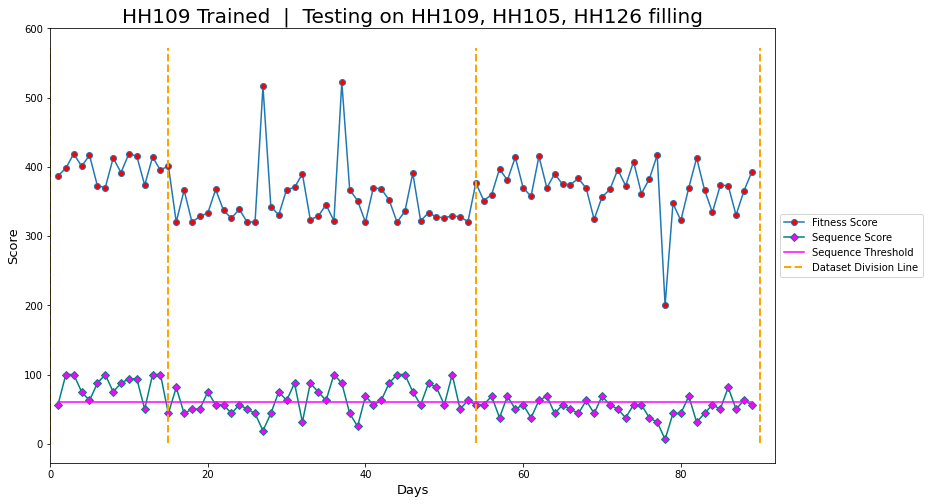

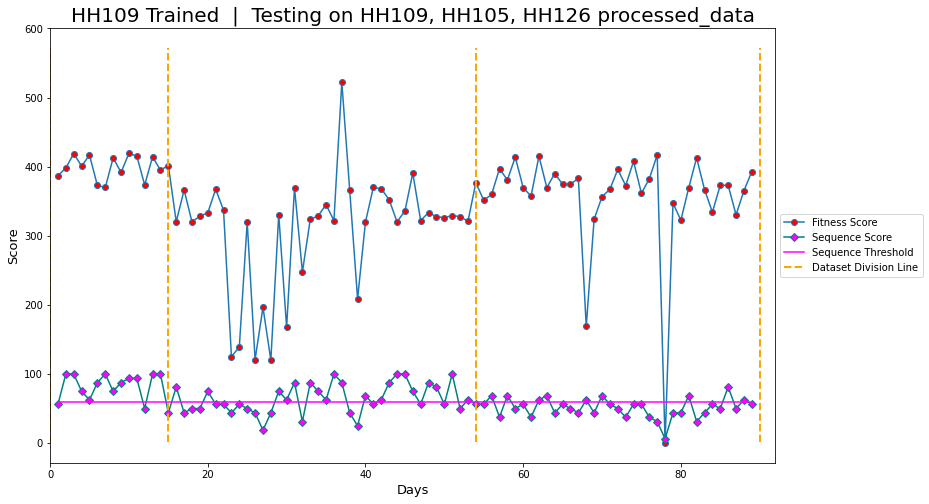

In [20]:
#2
get_fitness_plot('109', [ '109','105', '126'], 'filling')
get_fitness_plot('109', [ '109','105', '126'], 'processed_data')

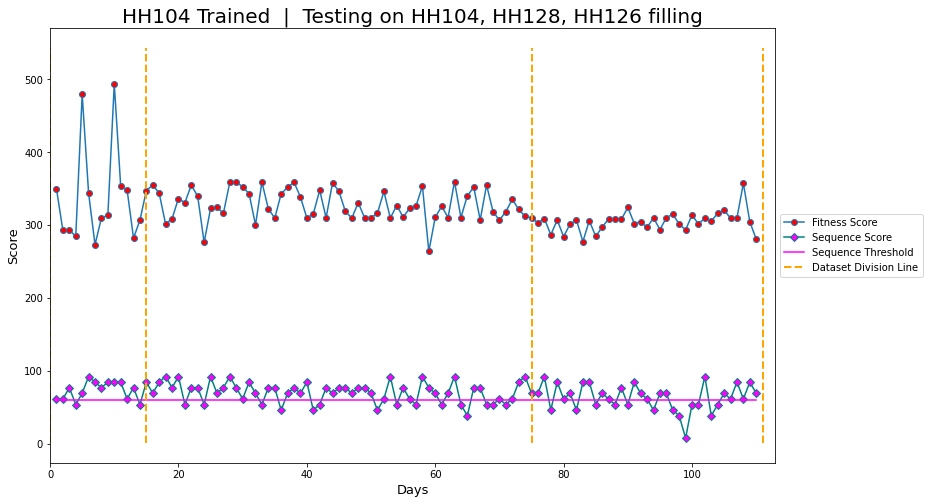

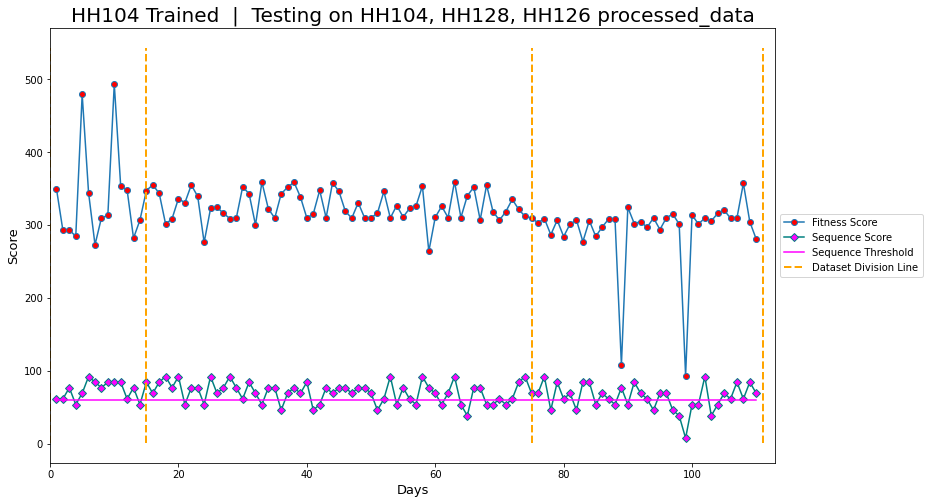

In [21]:
#3
get_fitness_plot('104', ['104','128', '126'], 'filling')
get_fitness_plot('104', ['104','128', '126'], 'processed_data')

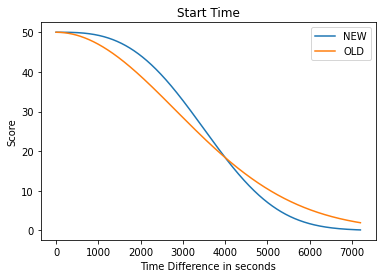

In [10]:
def fit2(x):

    b = 4000**2
    C = 50
    
    score = C*exp(-(x**2/b))
    #core = score*t[act]
    return score

def fit(x):

    n = 3
    b = 4000
    C = 50
    
    score = C*exp(-(x/b)**n)
    #core = score*t[act]
    return score
    
X= np.arange(0, 7200, 1)
Y = [fit(x) for x in X]
plt.plot(X, Y, label = 'NEW')
plt.xlabel('Time Difference in seconds')
plt.ylabel('Score')
plt.title('Start Time')                  
X1= np.arange(0, 7200, 1)
Y1 = [fit2(x) for x in X1]
plt.plot(X1, Y1, label = 'OLD')


plt.legend()

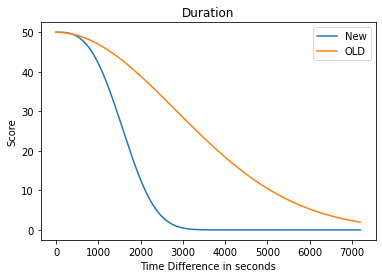

In [32]:
def fit2(x):

    b = 4000**2
    C = 50
    
    score = C*exp(-(x**2/b))
    #core = score*t[act]
    return score

def fit(x):

    n = 3
    b = 1800
    C = 50
    
    score = C*exp(-(x/b)**n)
    #core = score*t[act]
    return score
    
X= np.arange(0, 7200, 1)
Y = [fit(x) for x in X]
plt.plot(X, Y, label = 'New')
plt.xlabel('Time Difference in seconds')
plt.ylabel('Score')
plt.title('Duration')           
X1= np.arange(0, 7200, 1)
Y1 = [fit2(x) for x in X1]
plt.plot(X1, Y1, label = 'OLD')


plt.legend()